In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, ConciseDateFormatter
from pathlib import Path

# 1) Read daily dataset
path = Path("FCR_BVR_Met_daily_obs_2019_2024.csv")
df = pd.read_csv(path)

# 2) Parse date and index
date_col = "Date" if "Date" in df.columns else df.columns[0]
df[date_col] = pd.to_datetime(df[date_col])
df = df.set_index(date_col).sort_index()

# 3) Selecting FCR observation + MET variables
bvr_cols = [c for c in df.columns if c.startswith("BVR_")]
met_cols = [c for c in df.columns if c.startswith("mean_")] + ["sum_Rain_Total_mm"]
met_cols = [c for c in met_cols if c in df.columns]

# 4) One data structure
bvr_data = df[bvr_cols + met_cols].copy()

# 5) Quick checks
#print("Rows, Cols:", fcr_met.shape)
#print("BVR columns:", len(bvr_cols))
#print("MET columns:", len(met_cols))
#print(bvr_data.head())

# 6) plotting for quick checks
#cols = bvr_data.select_dtypes("number").columns.tolist()
#assert cols, "No numeric columns to plot."
#n, ncols = len(cols), 3
#nrows = math.ceil(n / ncols)

#fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
#                         figsize=(4.0*ncols, 2.2*nrows),
#                         dpi=300, sharex=True)
#axes = axes.flatten()
#locator = AutoDateLocator()
#formatter = ConciseDateFormatter(locator)

#for i, col in enumerate(cols):
#    ax = axes[i]
#    s =bvr_data[col]
#    ax.plot(s.index, s.values, lw=0.9, alpha=0.9)
#    ax.grid(True, alpha=0.25)
#    ax.set_title(col, fontsize=9)
#    ax.tick_params(labelsize=8)
#    ax.xaxis.set_major_locator(locator)
#    ax.xaxis.set_major_formatter(formatter)
#    if i < (nrows-1)*ncols:
#        ax.tick_params(axis='x', labelbottom=False)

#for j in range(i+1, len(axes)):
#    axes[j].axis("off")

#fig.suptitle("BVR + MET — Daily Time Series", fontsize=12)
#fig.tight_layout(rect=[0, 0.02, 1, 0.97])
# fig.savefig("fcr_met_daily_multipanel.png", bbox_inches="tight", dpi=300)
#plt.show()

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
import warnings
from sklearn.exceptions import FitFailedWarning
warnings.filterwarnings("ignore", category=FitFailedWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.model_selection._validation")
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.model_selection._search")



# Load & Preprocess
bvr_data["day_of_year"] = bvr_data.index.dayofyear
bvr_data = bvr_data.select_dtypes(include=[np.number]).dropna()


# Seasonality
bvr_data["sine"] = np.sin(2 * np.pi * bvr_data["day_of_year"] / 365.25)

# Prepare modeling data
bvr_data["year"]  = bvr_data.index.year
bvr_data["month"] = bvr_data.index.month

target_col = "BVR_mean_EXOChla_ugL_1.5"
drop_cols = ["year", "month", "day_of_year"]

X = bvr_data.drop(columns=drop_cols + [target_col], errors="ignore")
y = bvr_data[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Models & grids
models = {
    'XGBoost': (
        xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
        {
          'n_estimators':       [200, 400, 500],
          'max_depth':          [5,6,7,8,10],
          'learning_rate':      [0.03,0.05,0.1],
          'subsample':          [0.7,0.8,0.9],
          'colsample_bytree':   [0.7,0.8,0.9],
          'gamma':              [1,3,5],
          'reg_alpha':          [0.5, 1],
          'reg_lambda':         [5,10,20],
          'min_child_weight':   [2,5,7,9],
        }
    ),
    'RandomForest': (
        RandomForestRegressor(random_state=42, n_jobs=-1),
        {
            'n_estimators':      [200, 400, 500],
            'max_depth':         [None, 2, 4, 6, 9],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf':  [1, 2, 4, 6],
            'max_features':      ['sqrt', 0.5, None, 'auto'],
            'bootstrap':         [True],
        }
    ),
    'CatBoost': (
        CatBoostRegressor(random_state=42, silent=True),
        {
            'iterations':         [200, 400, 500],
            'depth':              [4, 6, 8],
            'learning_rate':      [0.03, 0.05, 0.1],
            'l2_leaf_reg':        [1, 3, 5, 7],
            'rsm':                [0.2, 0.3, 0.4, 0.6],
            'bagging_temperature':[0, 0.5, 1],
            'random_strength':     [0.5, 1.0, 2.0],
        }
    ),
    'GBM': (
        GradientBoostingRegressor(random_state=42),
        {
            'n_estimators':      [200, 400, 500],
            'learning_rate':     [0.01, 0.03, 0.05, 0.1],
            'max_depth':         [2, 4, 6],
            'min_samples_split': [2, 3, 5],
            'min_samples_leaf':  [2, 4, 6],
            'max_features':      ['sqrt', 0.5, None],
        }
    ),
}

# selecting model for quick checks
models = {k: v for k, v in models.items() if k == 'XGBoost'}

best_models = {}
results = {}
start_total = time.time()


# Grid search & evaluate
for name, (model, grid_params) in models.items():
    print(f"\n*** Tuning {name} ***")
    gs = GridSearchCV(
        estimator=model,
        param_grid=grid_params,
        scoring='r2',
        cv=5,
        n_jobs=-1,
#        verbose=1
    )
    t0 = time.time()
    gs.fit(X_train, y_train)
    best = gs.best_estimator_
    best_models[name] = best

    y_tr = best.predict(X_train)
    y_te = best.predict(X_test)

    results[name] = {
        'RMSE':  np.sqrt(mean_squared_error(y_test,  y_te)),
        'MAE':   mean_absolute_error(y_test,  y_te),
        'R':     np.corrcoef(y_test,  y_te)[0, 1],
    }

    print(f"Best params for {name}: {gs.best_params_}")
    print(f"{name} tuning time: {time.time() - t0:.1f}s")

print(f"\nTotal tuning time: {time.time() - start_total:.1f}s")

# Summary
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df)


*** Tuning XGBoost ***
Best params for XGBoost: {'colsample_bytree': 0.9, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 7, 'n_estimators': 400, 'reg_alpha': 0.5, 'reg_lambda': 5, 'subsample': 0.7}
XGBoost tuning time: 433.2s

Total tuning time: 433.2s

Model Comparison:
             RMSE       MAE         R
XGBoost  2.344398  1.731724  0.864553


Model Performance:
  XGBoost: R = 0.865, RMSE = 2.344


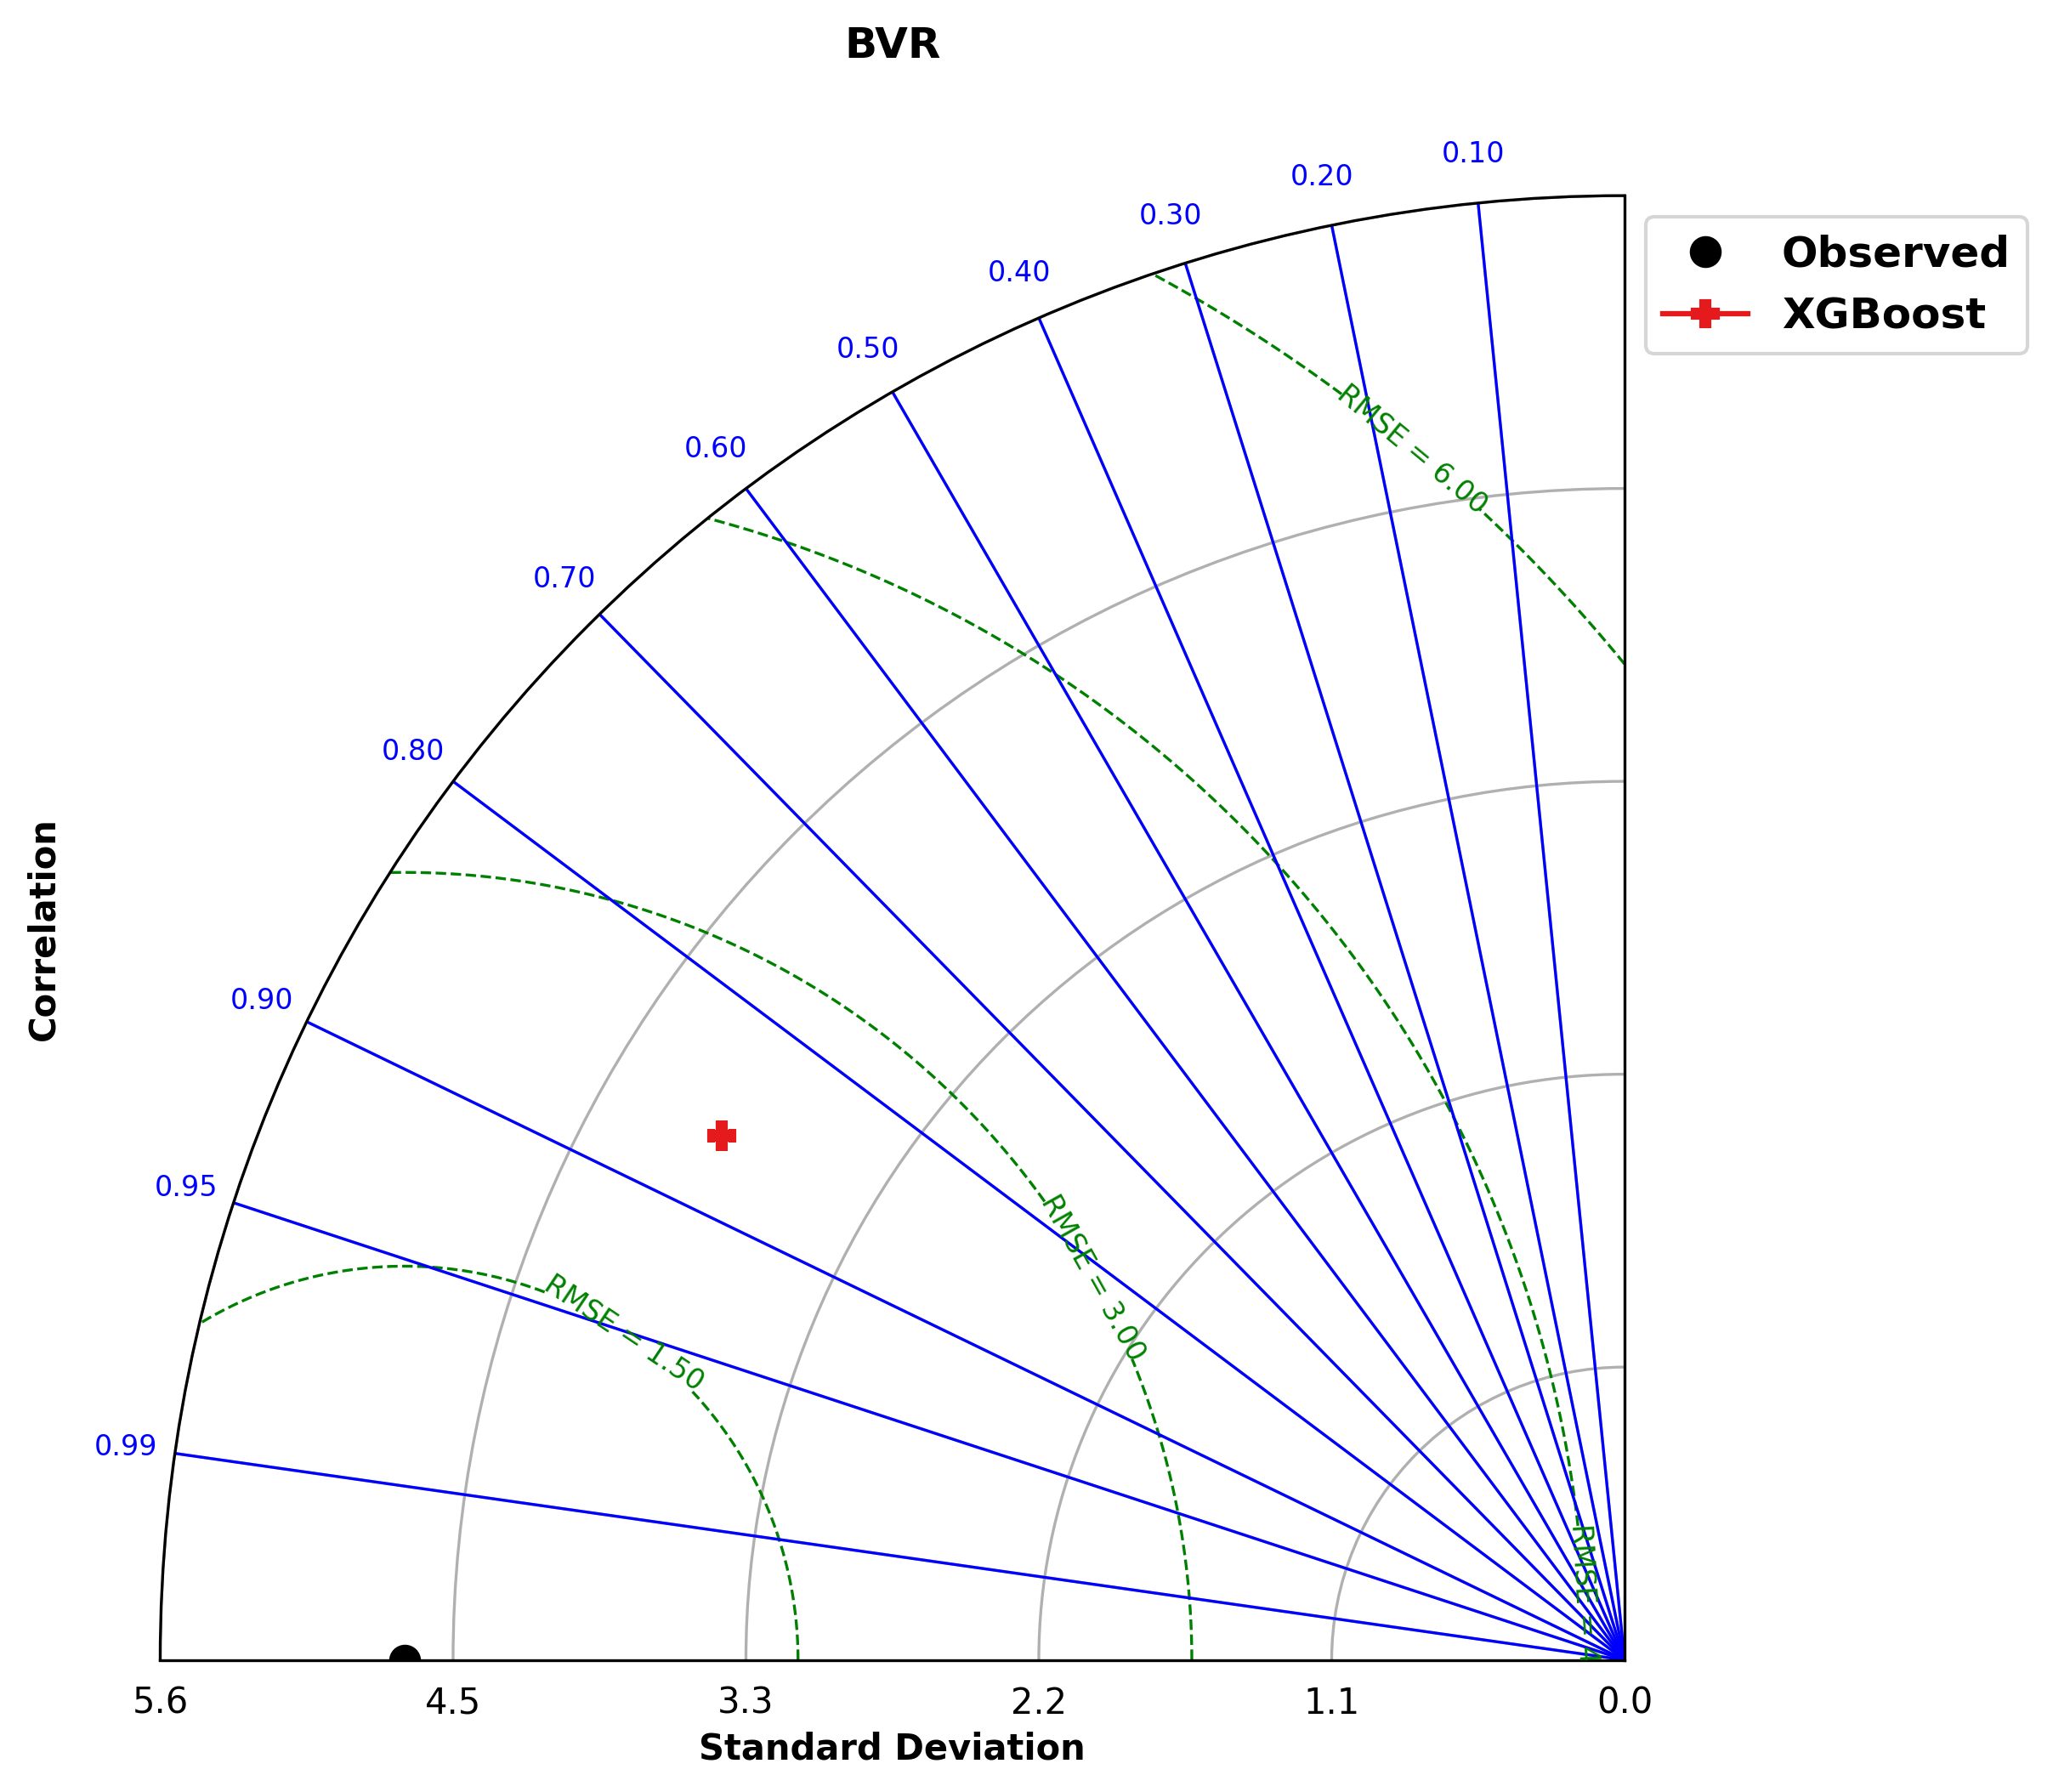

In [3]:
# Taylor Diagram 

def taylor_diagram(observed, predictions_dict, save_path="Taylor_diagram_BVR_FINAL"):

    # Compute reference statistics
    ref_std = np.std(observed, ddof=0)
    
    labels, stds, corrs, rmses = [], [], [], []
    for name, pred in predictions_dict.items():
        labels.append(name)
        stds.append(np.std(pred, ddof=0))
        corrs.append(np.corrcoef(observed, pred)[0,1])
        rmses.append(np.sqrt(np.mean((pred - observed)**2)))
    
    stds  = np.array(stds)
    corrs = np.array(corrs)
    rmses = np.array(rmses)
    
    # Print metrics
    print("Model Performance:")
    for name, r, rmse in zip(labels, corrs, rmses):
        print(f"  {name}: R = {r:.3f}, RMSE = {rmse:.3f}")
    
    # Set up polar axes
    fig, ax = plt.subplots(subplot_kw={'polar': True}, figsize=(8,8), dpi=300)
    ax.set_theta_zero_location("W")
    ax.set_theta_direction(-1)
    ax.set_thetamin(0)
    ax.set_thetamax(90)
    
    # Grid of RMSE contours
    max_std = max(ref_std, stds.max()) * 1.2
    rs, ts = np.meshgrid(
        np.linspace(0, max_std, 200),
        np.linspace(0, np.pi/2, 200)
    )
    rms = np.sqrt(ref_std**2 + rs**2 - 2*ref_std*rs*np.cos(ts))
    contours = ax.contour(
        ts, rs, rms,
        levels=5,
        colors='green',
        linestyles='dashed',
        linewidths=0.8
    )
    ax.clabel(contours, fmt="RMSE = %.2f", inline=True, fontsize=8)
    
    # Correlation lines
    corr_vals = [0.1, 0.2, 0.3,0.4, 0.5, 0.6,0.7, 0.8, 0.9, 0.95, 0.99]
    for c in corr_vals:
        theta = np.arccos(c)
        ax.plot([theta, theta], [0, max_std], color='blue', lw=0.8)
    
    # Axis ticks
    ax.set_ylim(0, max_std)
    ax.set_yticks(np.linspace(0, max_std, 6))
    ax.set_yticklabels([f"{s:.1f}" for s in np.linspace(0, max_std, 6)], fontsize=8)
    ax.set_xticks(np.arccos(corr_vals))
    ax.set_xticklabels([f"{c:.2f}" for c in corr_vals], fontsize=8, color='blue')
    
    # Reference point
    ax.plot(0, ref_std, 'o', color='black', markersize=8, label="Observed")
    
    # Model points
    colors = plt.cm.Set1(np.linspace(0,1,len(labels)))
    markers = ['P','^','s','D','P','X']
    for i, (std, corr, name) in enumerate(zip(stds, corrs, labels)):
        theta = np.arccos(corr)
        ax.plot(
            theta, std,
            marker=markers[i % len(markers)],
            color=colors[i],
            markersize=7,
            label=f"{name}"
        )
    
    # Labels & legend
    ax.set_xlabel("Standard Deviation", fontsize=10, fontweight='bold', labelpad=20)
    ax.set_ylabel("Correlation", fontsize=10, fontweight='bold', labelpad=20)  
    ax.set_title("BVR", fontsize=12, fontweight='bold', y=1.08)

    # Manual placement of legend
    legend=ax.legend(
        bbox_to_anchor=(1.0, 1.0),
        fontsize=12,
        frameon=True
    )
    
    for text in legend.get_texts():
        text.set_fontweight('bold')

    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

# usage:
observed = y_test.values
predictions = {name: model.predict(X_test) for name, model in best_models.items()}

taylor_diagram(observed, predictions, save_path="taylor_diagram_models_bvr_final.png")

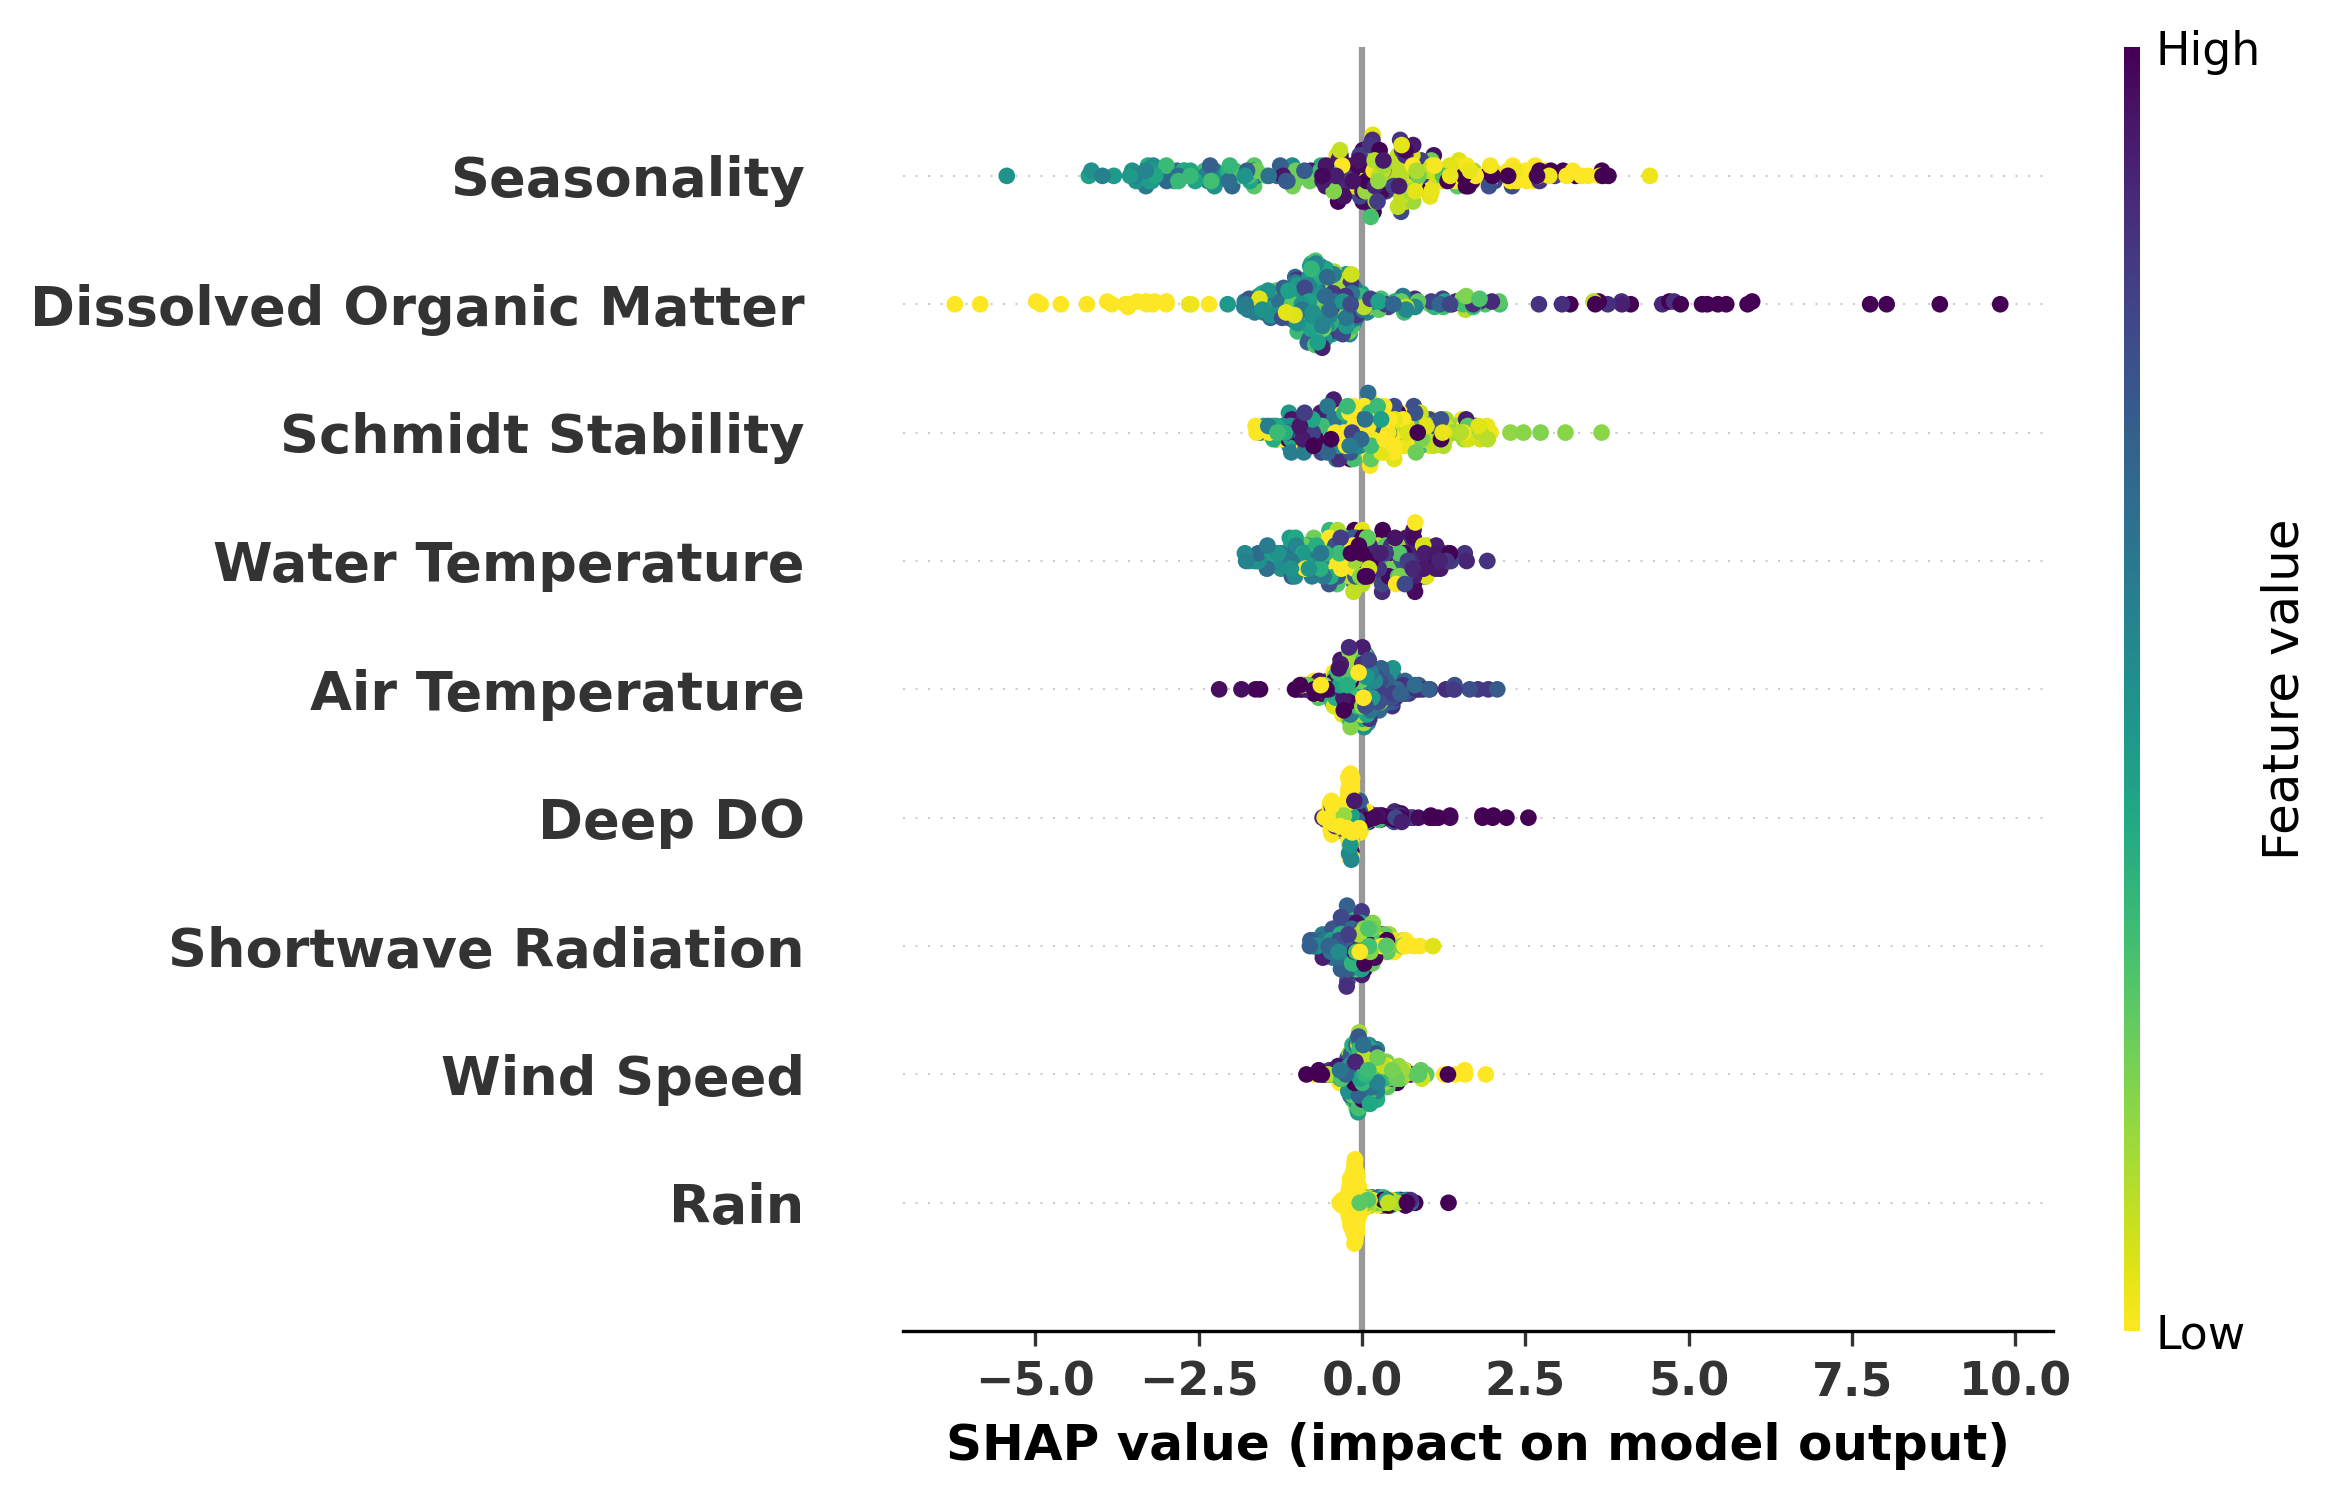

/localscratch/74160/ipykernel_2326057/2448408399.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis_r")


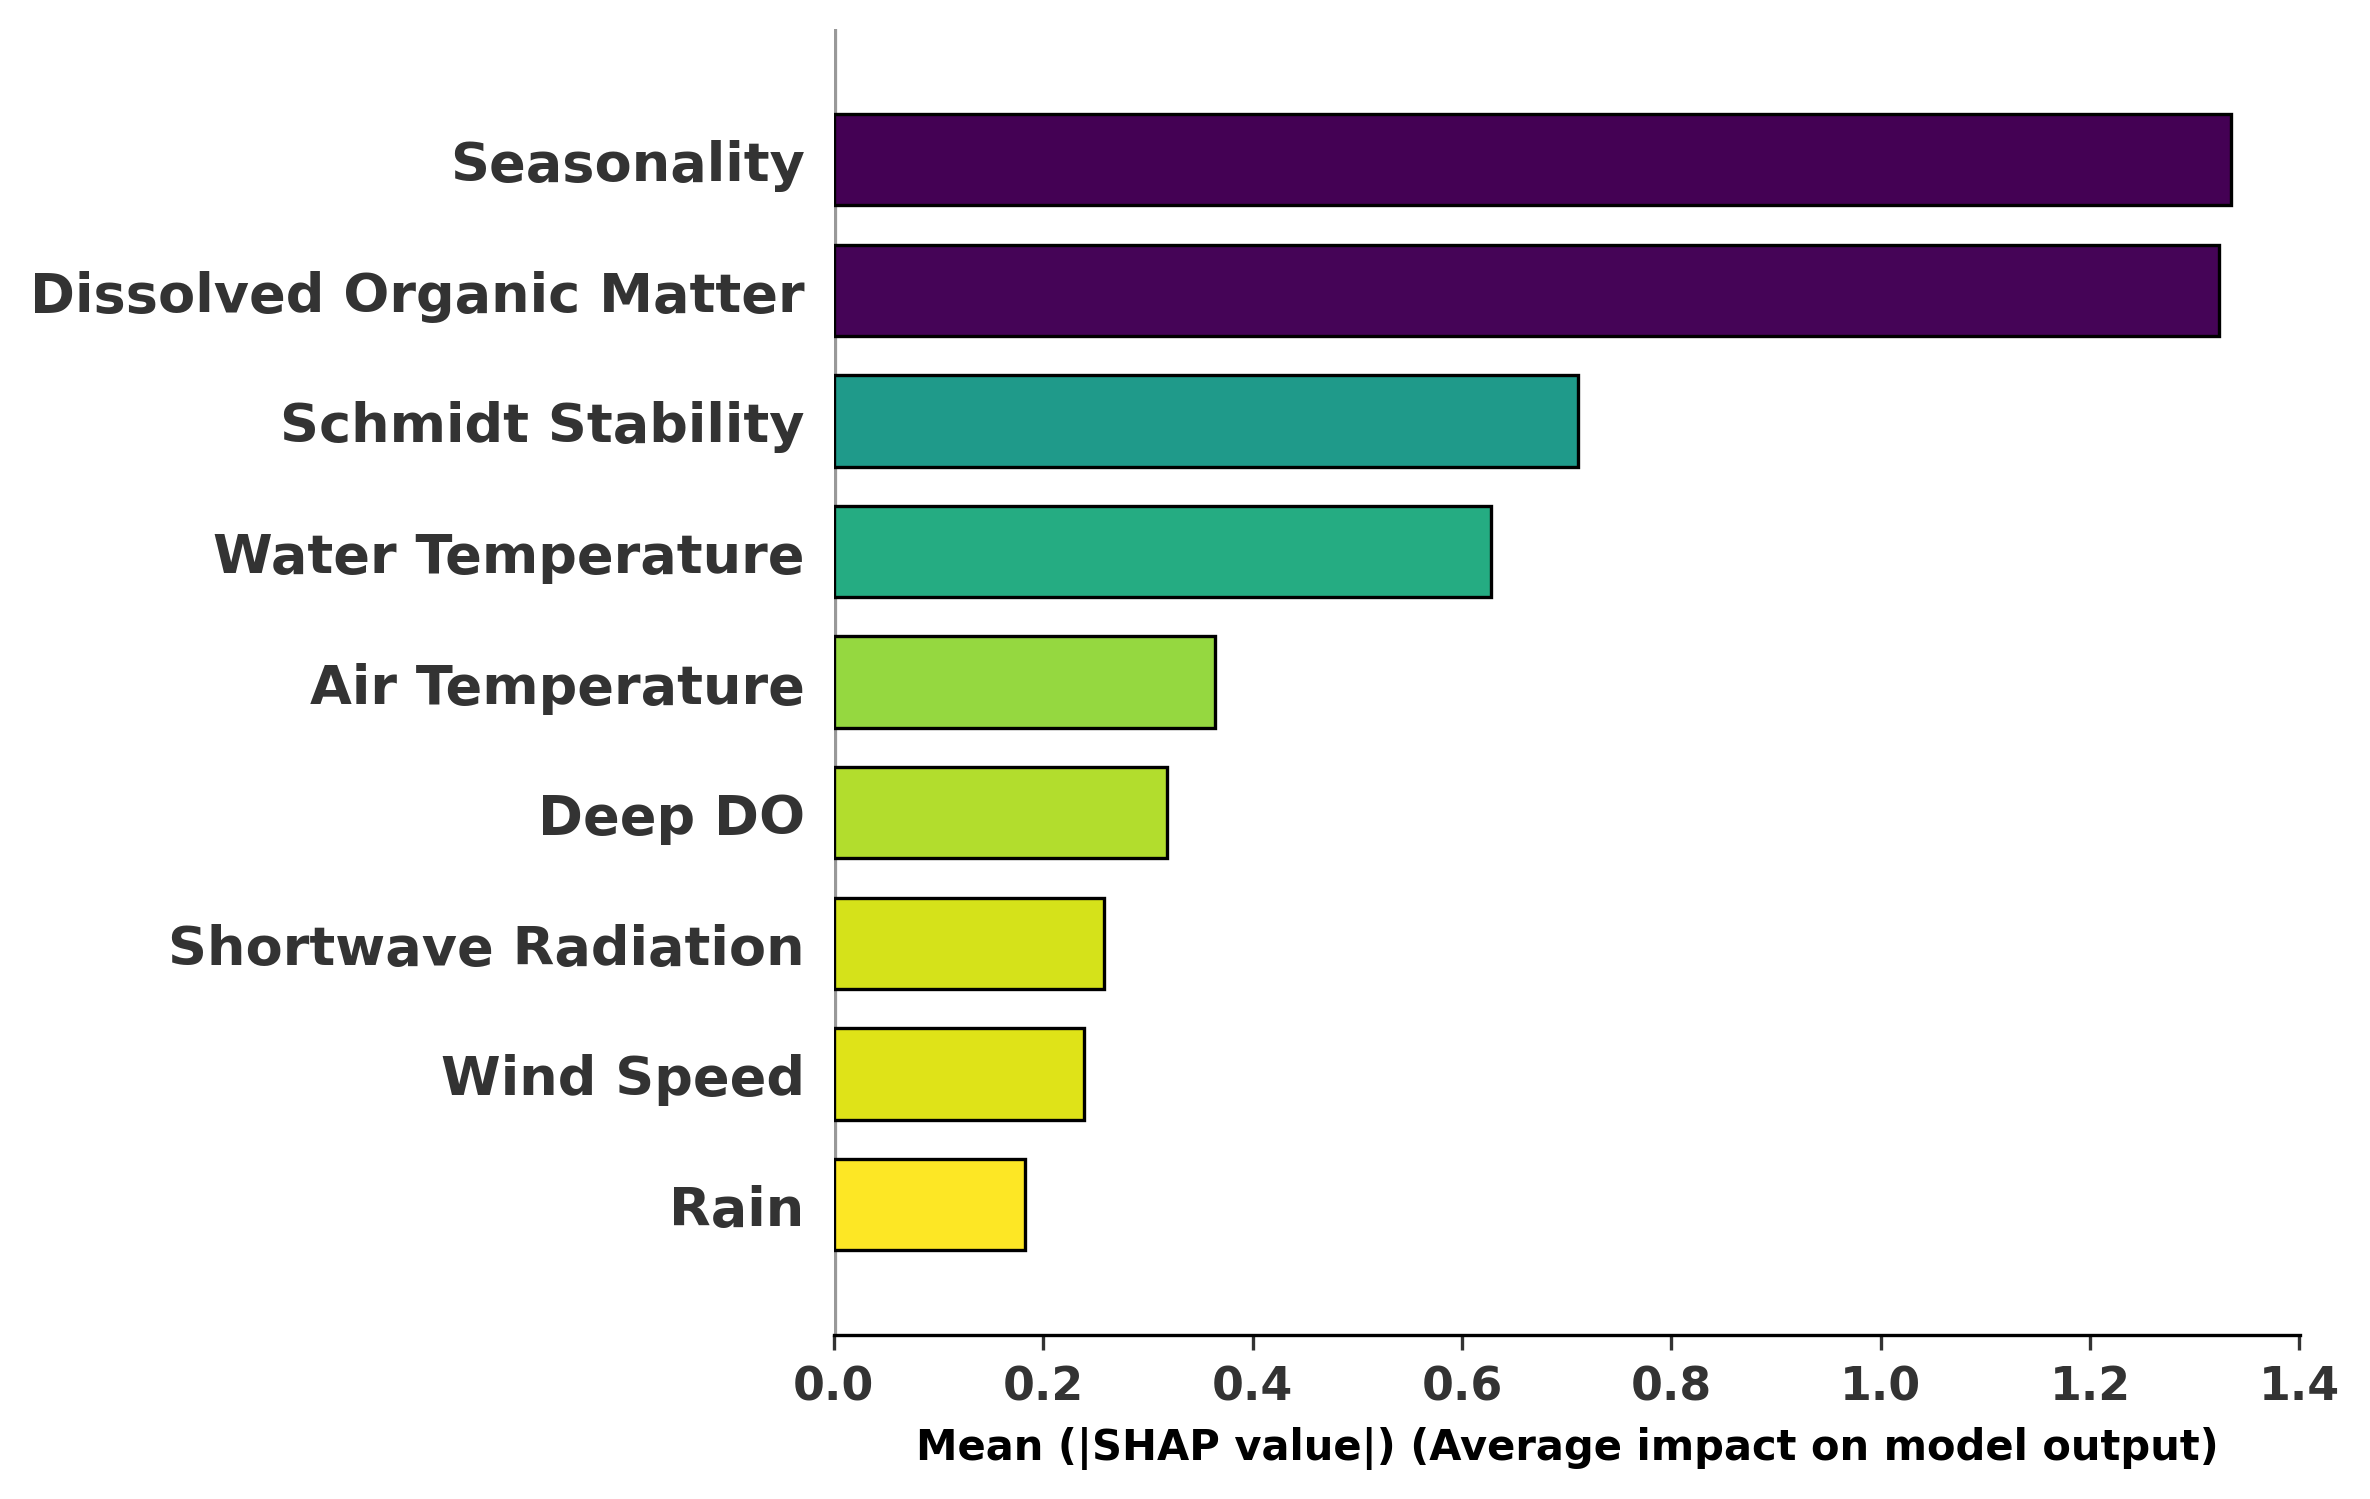

In [4]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import Normalize

# 1) Renaming for plotting
rename_map = {
    'BVR_mean_schmidt_stability': 'Schmidt Stability',
    'BVR_mean_RDOsat_percent_13': 'Deep DO',
    'BVR_mean_EXOTemp_C_1.5': 'Water Temperature',
    'BVR_mean_EXOfDOM_QSU_1.5': 'Dissolved Organic Matter',
    'sum_Rain_Total_mm': 'Rain',
    'mean_AirTemp_C_Average': 'Air Temperature',
    'mean_WindSpeed_Average_m_s': 'Wind Speed',
    'mean_ShortwaveRadiationUp_Average_W_m2': 'Shortwave Radiation',
    'sine': 'Seasonality'
}
X_train_renamed = X_train.rename(columns=rename_map)
X_test_renamed  = X_test.rename(columns=rename_map)

# 2) Build the SHAP Eexplainer on the best model 
shap_explainer = shap.TreeExplainer(best_models['XGBoost'])

train_shap_vals = shap_explainer.shap_values(X_train_renamed)
test_shap_vals  = shap_explainer.shap_values(X_test_renamed)

# ── A) SHAP Beeswarm Plot─────────────────────────────────────────
plt.figure(figsize=(7, 5), dpi=300)
shap.summary_plot(
    test_shap_vals,
    X_test_renamed,
    plot_type="dot",
    cmap="viridis_r",   
    show=False
)
#plt.title("XGBoost SHAP Beeswarm", fontsize=14, fontweight='bold')
plt.xlabel("SHAP value (impact on model output)", fontsize=12, fontweight='bold')
#plt.ylabel("Features (sorted by importance)", fontsize=12, fontweight='bold')
ax = plt.gca()
for lbl in ax.get_xticklabels(): lbl.set_fontweight('bold')
for lbl in ax.get_yticklabels(): lbl.set_fontweight('bold')
plt.tight_layout()
plt.savefig("shap_plots_bvr/shap_beeswarm_bvr.png", bbox_inches='tight')
plt.show()


# Base plot
plt.figure(figsize=(7, 5), dpi=300)
shap.summary_plot(
    test_shap_vals,
    X_test_renamed,
    plot_type="bar",
    color="grey",   
    show=False
)

# plotting with colorbar 
ax = plt.gca()
widths = np.array([bar.get_width() for bar in ax.patches])
norm = Normalize(vmin=float(widths.min()), vmax=float(widths.max()) if widths.size else 1.0)
cmap = cm.get_cmap("viridis_r")

for bar, w in zip(ax.patches, widths):
    bar.set_facecolor(cmap(norm(w)))
    bar.set_edgecolor("black")
    bar.set_linewidth(0.8)

# Labels and styling
plt.xlabel("Mean (|SHAP value|) (Average impact on model output)", fontsize=10, fontweight="bold")
for lbl in ax.get_xticklabels(): lbl.set_fontweight("bold")
for lbl in ax.get_yticklabels(): lbl.set_fontweight("bold")

plt.tight_layout()
plt.savefig("shap_plots_bvr/shap_bar_bvr.png", bbox_inches="tight")
plt.show()



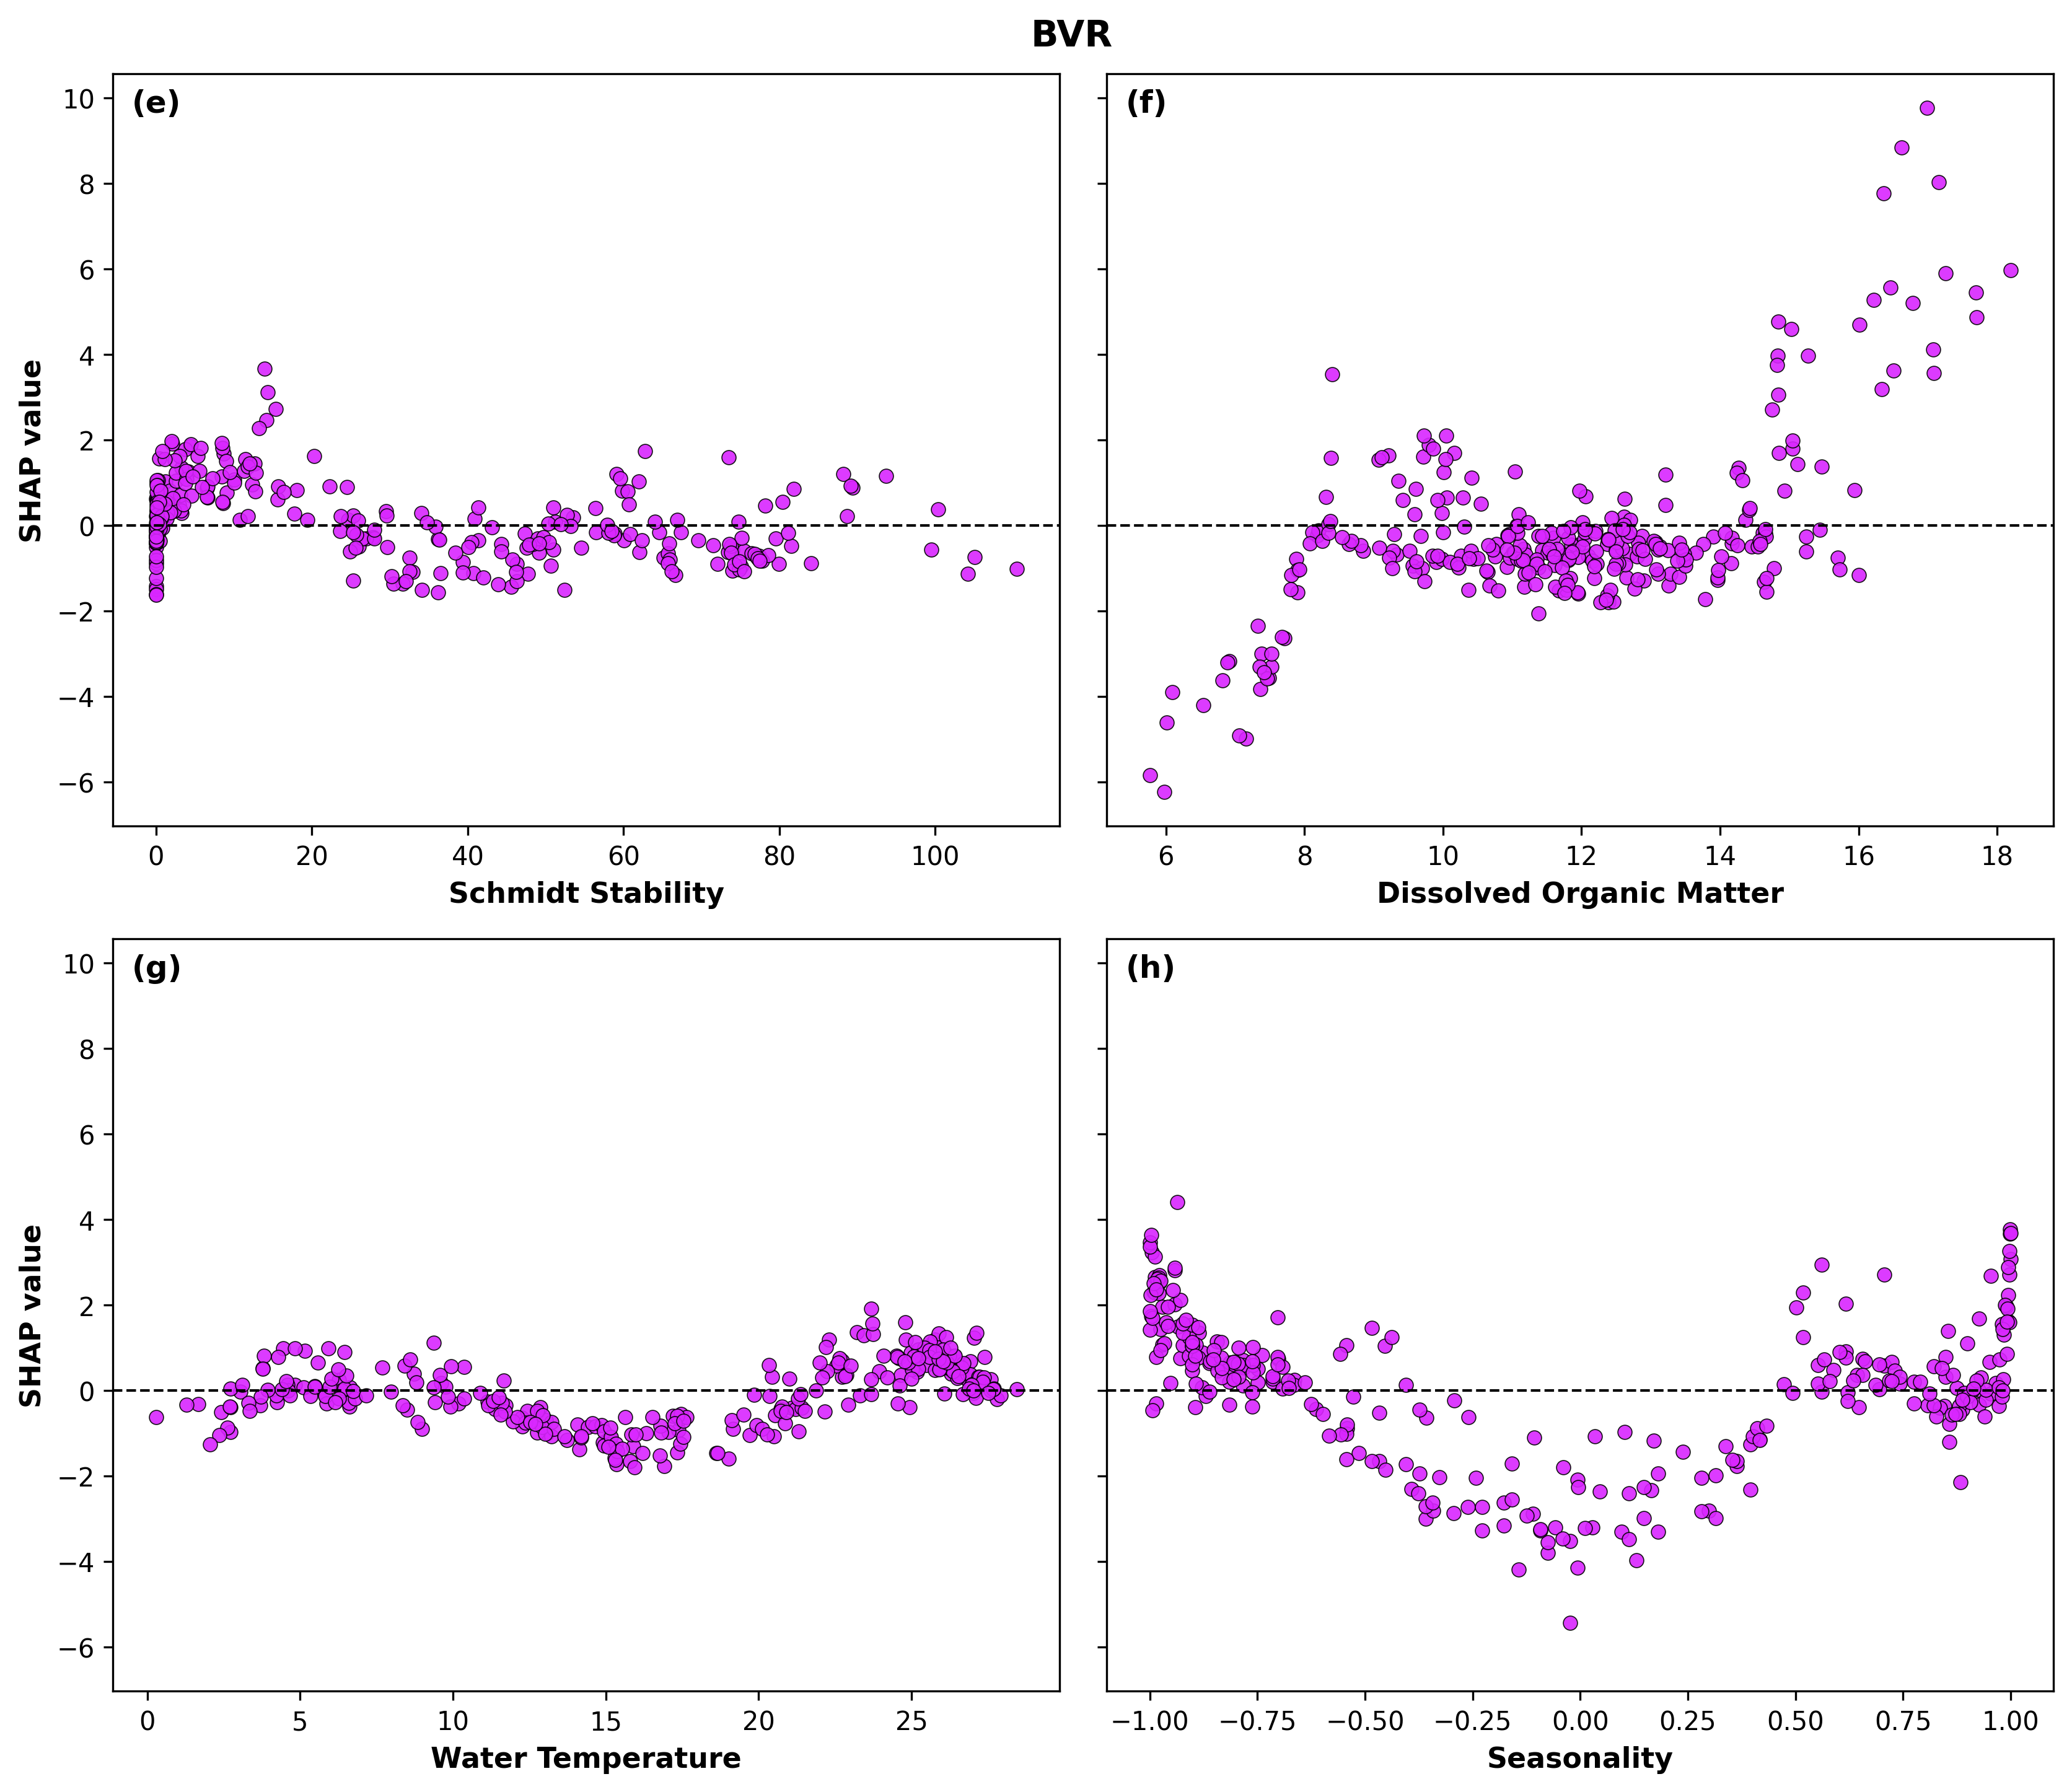

In [6]:
# partial dependency analyses

explainer = shap.TreeExplainer(best_models['XGBoost'])
shap_values_test = explainer.shap_values(X_test_renamed)

# 3) Choose the four features to plot
features_to_plot = [
    'Schmidt Stability',
    'Dissolved Organic Matter',
    'Water Temperature',
    'Seasonality'
]

# 4) Prepare the panel
cmap = plt.get_cmap("cool")
green_shade = cmap(0.85)

fig, axes = plt.subplots(
    nrows=2, ncols=2,
    figsize=(12, 10),
    dpi=300,
    sharey=True
)
axes = axes.flatten()

panel_labels = ['(e)', '(f)', '(g)', '(h)']
for i, ax in enumerate(axes[:len(features_to_plot)]):
    ax.text(0.02, 0.98, panel_labels[i],
            transform=ax.transAxes,
            va='top', ha='left',
            fontsize=12, fontweight='bold')

plt.subplots_adjust(
    left=0.08, right=0.95, bottom=0.08, top=0.95,
    wspace=0.001, hspace=0.05  # ↓ reduce vertical gap
)

for i, (ax, feat) in enumerate(zip(axes, features_to_plot)):
    x = X_test_renamed[feat]
    idx = X_test_renamed.columns.get_loc(feat)
    y = shap_values_test[:, idx]
    
# 5a) Scatter plot 
    ax.scatter(
        x, y,
        s=30,
        alpha=0.9,
        facecolor=green_shade,
        edgecolor='black',
        linewidth=0.4
    )

#    ax.plot(df_plot.index, df_plot[col].values, lw=LW, alpha=ALPHA, color=LINE_COLOR)
    ax.axhline(0, color='black', linestyle='--', linewidth=1)

    # 5b) Titles and labels
    ax.set_xlabel(feat, fontsize=11, fontweight='bold')
    if i in [0, 2]:
        ax.set_ylabel("SHAP value", fontsize=11, fontweight='bold')


# 6) Hide any unused axes
for ax in axes[len(features_to_plot):]:
    ax.axis('off')

# 7) Final layout, save figure
plt.subplots_adjust(
    left=0.08,  # Left margin
    right=0.95, # Right margin
    bottom=0.08, # Bottom margin
    top=0.95,   # Top margin
    wspace=0.05, # Horizontal space between subplots
    hspace=0.15  # Vertical space between subplots
)
fig.suptitle("BVR", fontsize=14, fontweight="bold",x=0.51, y=0.98)
plt.savefig("shap_plots_bvr/shap_dependence_bvr.png", bbox_inches='tight')
plt.show()

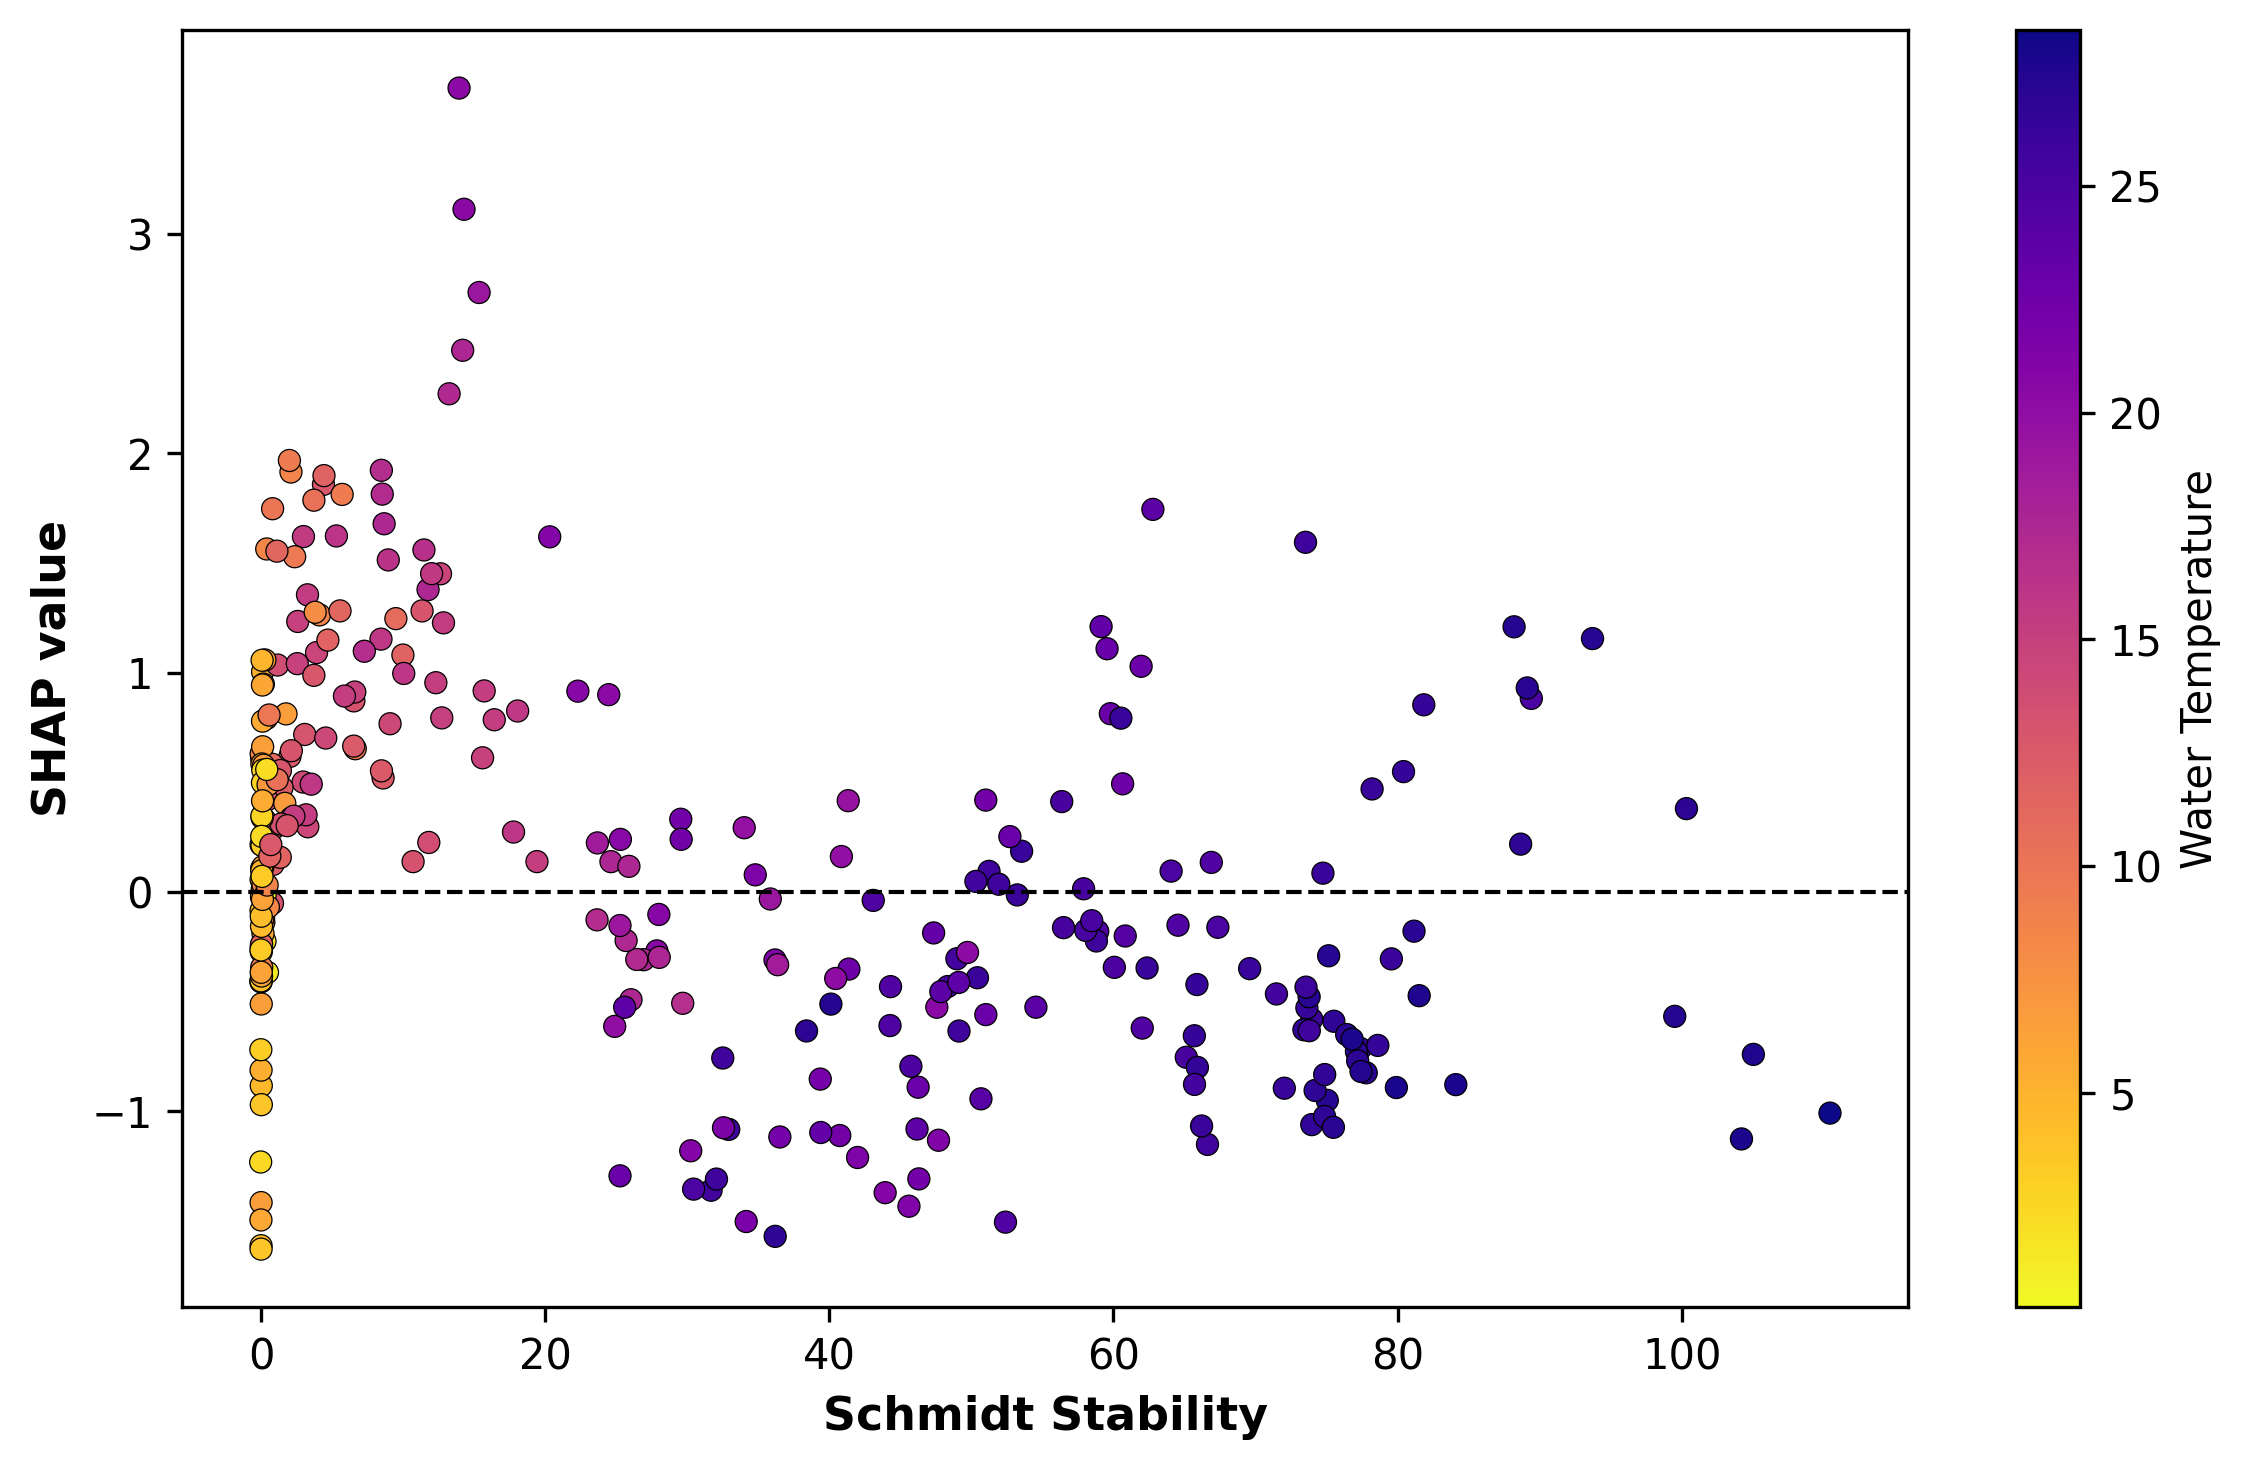

In [7]:
# Interaction analyses

explainer = shap.TreeExplainer(best_models["XGBoost"])
shap_values_test = explainer.shap_values(X_test_renamed)

# Single panel: x = Schmidt Stability, color = Water Temperature
x_feat = "Schmidt Stability"
c_feat = "Water Temperature"
cmap = "plasma_r"

x = X_test_renamed[x_feat].values
c = X_test_renamed[c_feat].values
y = shap_values_test[:, X_test_renamed.columns.get_loc(x_feat)]

plt.figure(figsize=(8, 5), dpi=300)
sc = plt.scatter(x, y, c=c, cmap=cmap, s=28, edgecolors="black", linewidths=0.3)
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.xlabel(x_feat, fontsize=11, fontweight="bold")
plt.ylabel("SHAP value", fontsize=11, fontweight="bold")
cb = plt.colorbar(sc)
cb.set_label(c_feat, fontsize=10)
plt.tight_layout()
plt.savefig("shap_ss_vs_temp_bvr.png", bbox_inches="tight")
plt.show()


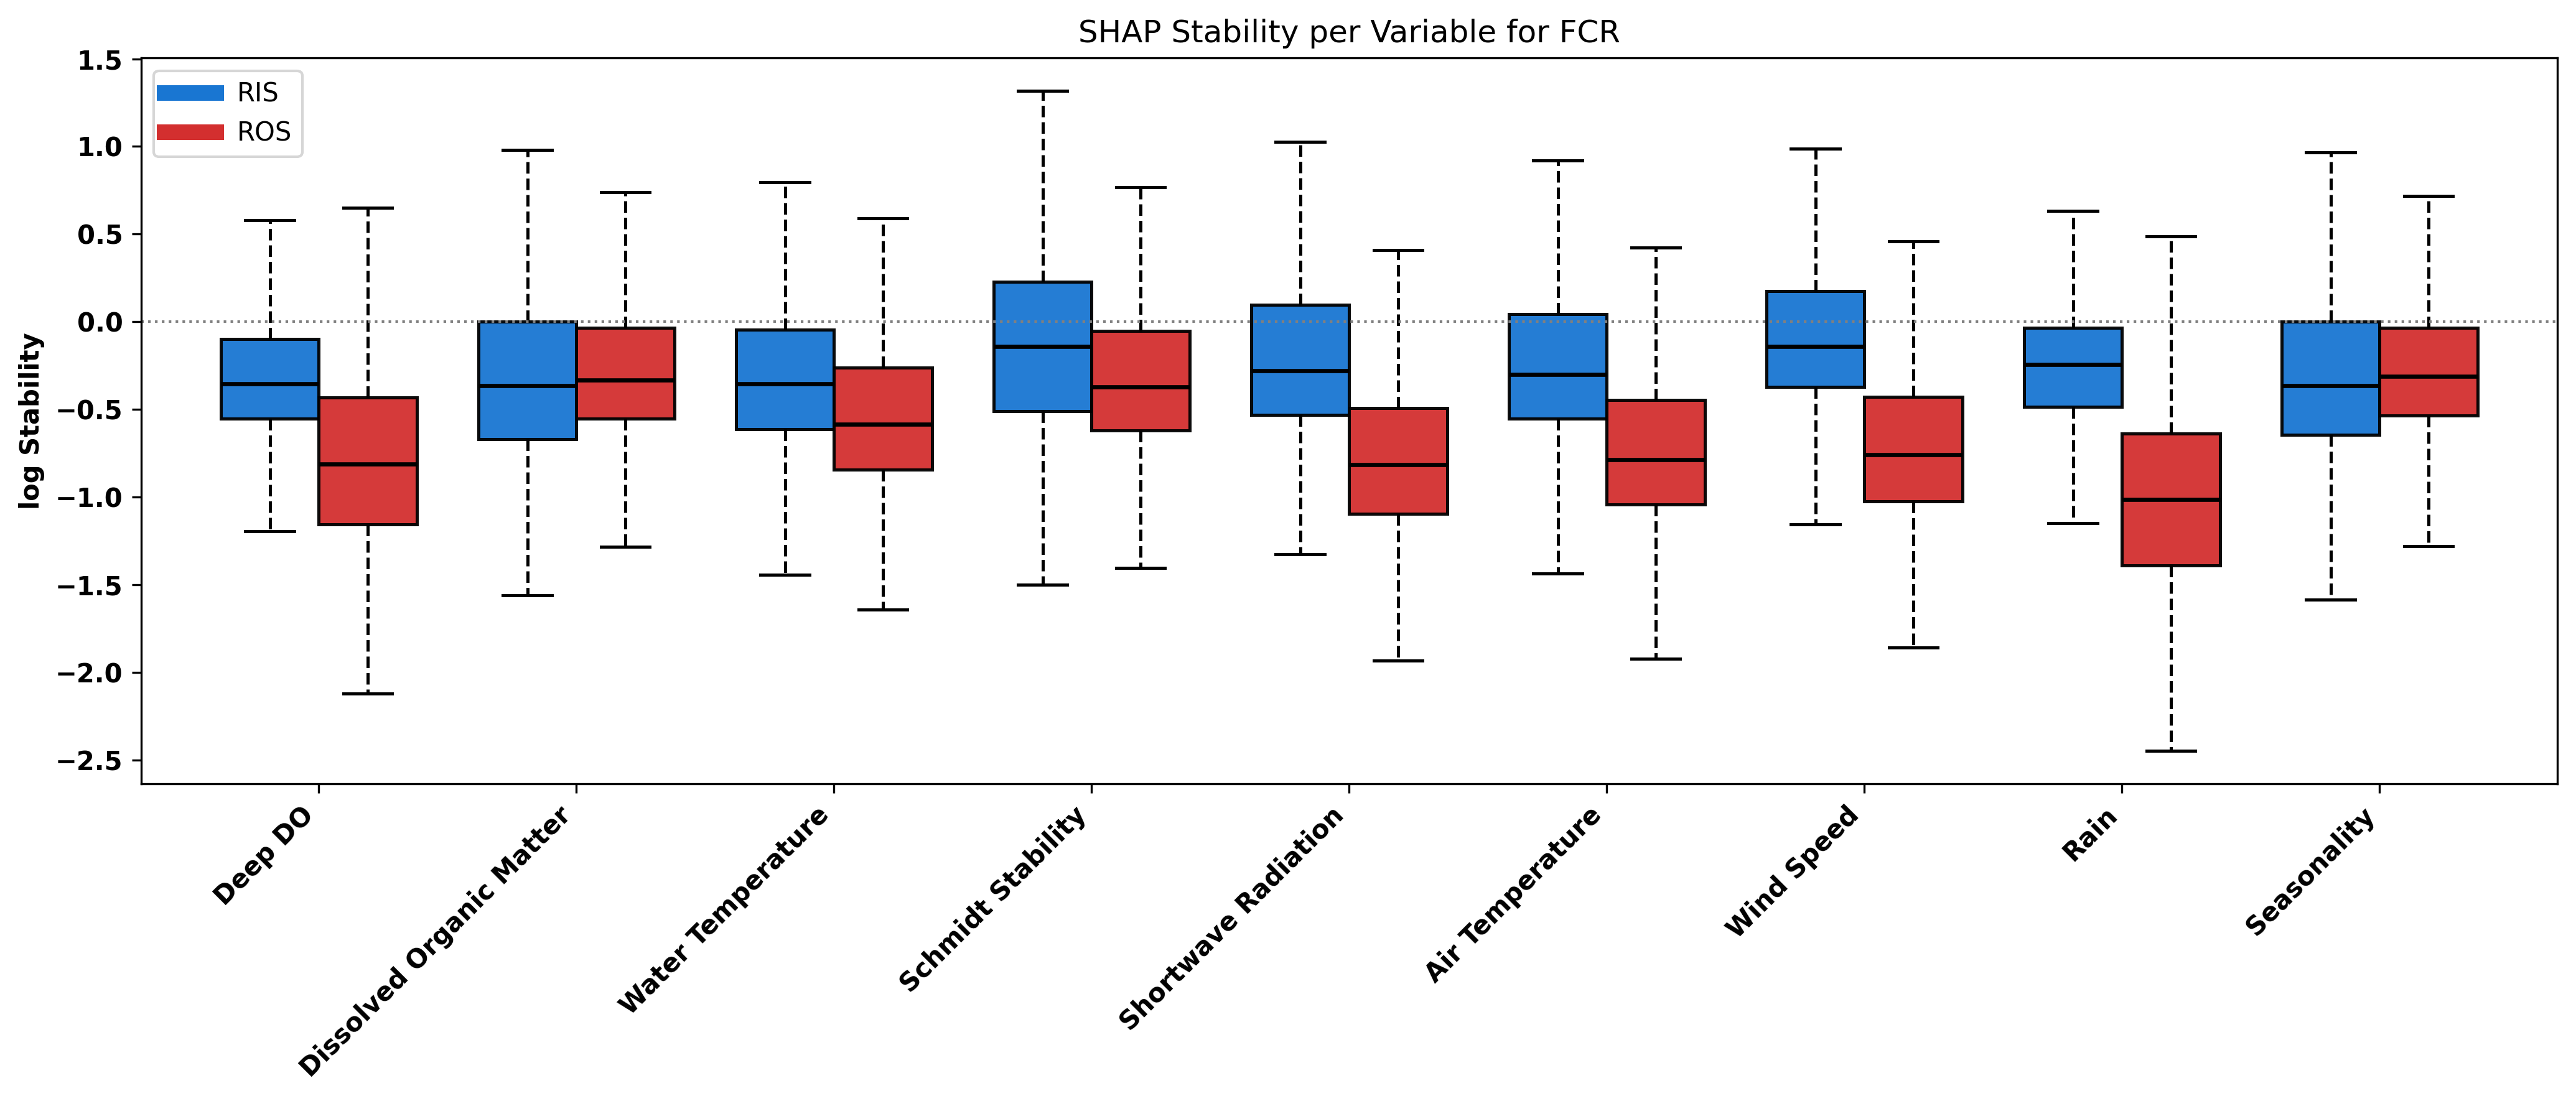

In [8]:
import numpy as np
import shap
import torch
import matplotlib.pyplot as plt
import os

# 1) setup
model = best_models['XGBoost']
explainer = shap.TreeExplainer(model)
X = X_train_renamed.to_numpy(dtype=float)
feat_names = list(X_train_renamed.columns)
n, d = X.shape

# --- Standardization---
mu  = X.mean(axis=0)
std = X.std(axis=0)
std = np.where(np.isfinite(std) & (std > 0), std, 1.0)  

# 2) Perturbation utility 
class Perturb:
    def __init__(self, strength=0.10, seed=42):
        self.strength = strength
        self.rng = np.random.default_rng(seed)
        torch.manual_seed(seed)
    def apply(self, x, mask, n_perturbs):
        x_t = torch.tensor(x, dtype=torch.float32)
        out = []
        for _ in range(n_perturbs):
            noise = torch.randn_like(x_t) * self.strength
            out.append(x_t + noise * torch.tensor(mask, dtype=torch.float32))
        return torch.stack(out).numpy()

pert = Perturb(strength=0.10, seed=42)
mask = np.ones(d, dtype=bool)  # perturb all features

# 3) Per-feature RIS and ROS matrices 
def per_feature_ris_ros(X_orig, n_perturbs=5, eps=1e-6):
    ris_list, ros_list = [], []
    for i in range(len(X_orig)):
        x0 = X_orig[i]                              
        shap0 = explainer.shap_values(x0.reshape(1, -1))[0]
        y0 = model.predict(x0.reshape(1, -1))[0]

        z0 = (x0 - mu) / std
        Zp = pert.apply(z0, mask, n_perturbs)       
        Xp = Zp * std + mu                         

        shap_p = np.array([explainer.shap_values(x.reshape(1, -1))[0] for x in Xp])
        y_p = np.array([model.predict(x.reshape(1, -1))[0] for x in Xp])

        # RIS: E[ |ΔSHAP| / (|SHAP|+eps) ]
        ris = np.mean(np.abs(shap_p - shap0) / (np.abs(shap0) + eps), axis=0)

        # ROS: E[ |ΔSHAP| / (|Δy|+eps) ]
        ros = np.mean(np.abs(shap_p - shap0) / (np.abs(y_p - y0) + eps).reshape(-1, 1), axis=0)

        ris_list.append(ris); ros_list.append(ros)

    return np.vstack(ris_list), np.vstack(ros_list)  # shapes: (n, d)

ris_mat, ros_mat = per_feature_ris_ros(X, n_perturbs=5)

# 4) Log10 stability boxplots per variable
def plot_log10(a, eps=1e-9): return np.log10(np.clip(a, eps, None))
box_ris = plot_log10(ris_mat)
box_ros = plot_log10(ros_mat)

pos = np.arange(d)
w = 0.38

plt.figure(figsize=(1.1*d + 4, 6), dpi=300)
# RIS
plt.boxplot(
    [box_ris[:, j] for j in range(d)],
    positions=pos - w/2, widths=w, patch_artist=True, showfliers=False,
    boxprops=dict(facecolor='#1976D2', alpha=0.95, linewidth=1.2, edgecolor='black'),
    medianprops=dict(color='black', linewidth=1.6),
    whiskerprops=dict(linewidth=1.2, color='black', linestyle='--'),
    capprops=dict(linewidth=1.2, color='black')
)
# ROS
plt.boxplot(
    [box_ros[:, j] for j in range(d)],
    positions=pos + w/2, widths=w, patch_artist=True, showfliers=False,
    boxprops=dict(facecolor='#D32F2F', alpha=0.95, linewidth=1.2, edgecolor='black'),
    medianprops=dict(color='black', linewidth=1.6),
    whiskerprops=dict(linewidth=1.2, color='black',linestyle='--'),
    capprops=dict(linewidth=1.2, color='black')
)

plt.xticks(pos, feat_names, rotation=45, ha='right')
plt.xticks(fontweight="bold")
plt.ylabel("log Stability",fontweight='bold')
plt.yticks(fontweight="bold")
plt.title("SHAP Stability per Variable for FCR")
plt.axhline(0, color='gray', linestyle=':', linewidth=1)
plt.legend(handles=[
    plt.Line2D([0],[0], color='#1976D2', lw=6, label='RIS'),
    plt.Line2D([0],[0], color='#D32F2F', lw=6, label='ROS')
], loc='upper left', frameon=True)

plt.tight_layout()
os.makedirs("shap_plots_bvr", exist_ok=True)
plt.savefig("shap_plots_bvr/boxplot_ris_ros_log_per_feature_bvr.png", bbox_inches='tight')
plt.show()

In [9]:
# ---- Medians values ----
import pandas as pd
med_log_ris = np.median(box_ris, axis=0)   
med_log_ros = np.median(box_ros, axis=0)   
med_ris     = 10**med_log_ris             
med_ros     = 10**med_log_ros              

med_df = pd.DataFrame({
    "Feature": feat_names,
    "Median_log10_RIS": med_log_ris,
    "Median_log10_ROS": med_log_ros,
#    "Median_RIS": med_ris,
#    "Median_ROS": med_ros,
})
print(med_df.round(3).to_string(index=False))

                 Feature  Median_log10_RIS  Median_log10_ROS
                 Deep DO            -0.354            -0.810
Dissolved Organic Matter            -0.364            -0.332
       Water Temperature            -0.353            -0.586
       Schmidt Stability            -0.141            -0.372
     Shortwave Radiation            -0.279            -0.816
         Air Temperature            -0.300            -0.785
              Wind Speed            -0.141            -0.759
                    Rain            -0.244            -1.013
             Seasonality            -0.363            -0.313
